In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import glob
%matplotlib inline

In [2]:
def CreateCsv(path,encoded_category,category):
    img = glob.glob(path)
    img = pd.DataFrame(img)
    img['path'] = img[0]
    img = img.drop([0],axis=1)
    img['label'] = encoded_category
    img['category'] = category
    return(img)


a = CreateCsv('face_dector/with_mask/*.jpg',0.0,'mask')
b = CreateCsv('face_dector/without_mask/*.jpg',1.0,'without_mask')

In [3]:
image = a.append(b,ignore_index=True)
image.head()

,path,label,category
0,face_dector/with_mask\0-with-mask.jpg,0.0,mask
1,face_dector/with_mask\1-with-mask.jpg,0.0,mask
2,face_dector/with_mask\10-with-mask.jpg,0.0,mask
3,face_dector/with_mask\100-with-mask.jpg,0.0,mask
4,face_dector/with_mask\101-with-mask.jpg,0.0,mask


In [4]:
def read_image(file_path):
    img = cv2.imread(file_path,cv2.IMREAD_COLOR)
    return cv2.resize(img,(150,150), interpolation = cv2.INTER_CUBIC)

In [5]:
def perpare_data(images):
    m = len(images)
    X = np.zeros((m,150,150,3), dtype=np.uint8)
    for i, image_file in enumerate(images):
        X[i,:] = read_image(image_file)
    return X

In [6]:
train_image = image['path']
train_set_X = perpare_data(train_image)
training_label = image['label']

In [8]:
print(train_image.shape)
train_set_X = train_set_X/255

(1372,)


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_set_X,training_label,test_size=0.20, random_state=42)

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [28]:
INIT_LR = 1e-4
EPOCHS = 15
BS = 32


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout

In [30]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer = 'adam', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [31]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(X_train, y_train,batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_test,y_test),
	validation_steps=len(X_test) // BS,
	epochs=EPOCHS)

[INFO] training head...
  ...
    to  
  ['...']
Train for 34 steps, validate on 275 samples
Epoch 1/15
34/34 [==============================] - 13s 371ms/step - loss: 0.6920 - acc: 0.6413 - val_loss: 0.3680 - val_acc: 0.8555
Epoch 2/15
34/34 [==============================] - 14s 400ms/step - loss: 0.3886 - acc: 0.8554 - val_loss: 0.1680 - val_acc: 0.9336
Epoch 3/15
34/34 [==============================] - 13s 381ms/step - loss: 0.2899 - acc: 0.8901 - val_loss: 0.1663 - val_acc: 0.9688
Epoch 4/15
34/34 [==============================] - 14s 406ms/step - loss: 0.2184 - acc: 0.9221 - val_loss: 0.1065 - val_acc: 0.9766
Epoch 5/15
34/34 [==============================] - 14s 415ms/step - loss: 0.2176 - acc: 0.9315 - val_loss: 0.0717 - val_acc: 0.9844
Epoch 6/15
34/34 [==============================] - 14s 416ms/step - loss: 0.1477 - acc: 0.9408 - val_loss: 0.0733 - val_acc: 0.9805
Epoch 7/15
34/34 [==============================] - 14s 409ms/step - loss: 0.1335 - acc: 0.9606 - val_loss: 0

In [32]:
pred = model.predict(X_test)

In [33]:
df = pd.DataFrame(pred,y_test,columns=['predicted'])

In [34]:
df.head()

,predicted
label,
0.0,0.052154
0.0,0.150307
0.0,0.001889
0.0,0.014662
0.0,0.002995


[[0.9939389]]
I think mask is present on the face of man


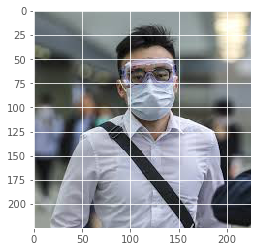

In [35]:
image = np.array(plt.imread('machime learing/flowers/images9.jpg').astype(float))
image = image/255.0
my_image = cv2.resize(image, dsize=(150,150)).reshape((1,150,150,3))
num = model.predict(my_image)
plt.imshow(image)
print(num)
if num>0.5:
    print("I think mask is present on the face of man")
elif num<0.5:
      print("I think mask is not present on the face of man")

In [36]:
from tensorflow.keras.models import load_model 
model.save("maskdetecter.h5") 
loaded_model = load_model("maskdetecter.h5") 

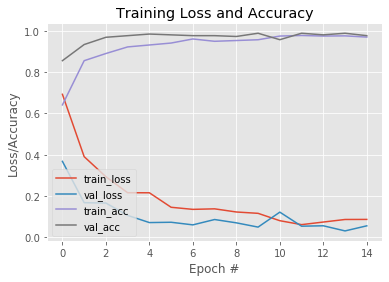

In [37]:
N=15
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
